<a href="https://colab.research.google.com/github/rohitrv8922/Speech-Emotion-Recognition-Detection/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project Introduction

Import Libraries

In [2]:
# Importing all the required Libraries

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential                                                            
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,GlobalMaxPool2D,Activation,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
import numpy as np 
import pandas as pd
import cv2
import os
from sklearn.metrics import confusion_matrix
import itertools
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.2


In [24]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

In [25]:
df='/content/drive/My Drive/'
face_df=pd.read_csv(df +'/Dataset/icml_face_data.csv',encoding='latin-1')
face_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [26]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label
  
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()                

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

In [29]:
face_df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [30]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [18]:
# Defining train and validation path
train_path = pd.read_csv('/content/drive/My Drive/Dataset/train.csv')
val_path = pd.read_csv('/content/drive/My Drive/Dataset/test.csv')

In [20]:
# data categories
categories = (train_path)
print(categories)

       emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  231 212 156 164 174 138 161 173 182 200 106 38...
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...                                                ...
28704        2  84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705        0  114 112 113 113 111 111 112 113 115 113 114 11...
28706        4  74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707        0  222 227 203 90 86 90 84 77 94 87 99 119 134 14...
28708        4  195 199 205 206 205 203 206 209 208 210 212 21...

[28709 rows x 2 columns]


In [31]:
# Creating a function for using for show some images from each categories
def imageshow(category):
  plt.figure(figsize= (8,8))
  for i in range(1, 10, 1):
      plt.subplot(3,3,i)
      img = load_img(train_path+'/'+category+"/"+
                    os.listdir(train_path + "/" + category)[i], target_size=(48,48))
      plt.imshow(img)
  plt.suptitle(category,fontsize=30)   
  plt.show()

UFuncTypeError: ignored

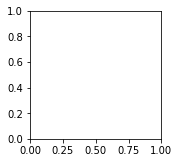

In [32]:
#Showing some images from category neutral
imageshow('neutral')